In [1]:
"""Topic: Exploring and visualizing NFL statistics in pandas)
Web scraping data from Pro-Football-Reference for analysis
"""

from bs4 import BeautifulSoup
import requests, re
import pandas as pd
import numpy as np

from stat_functions import all_position_stats, all_rb_defense_headers
from get_df import fantasy_points, get_running_back_df, all_individual_stats

import matplotlib.pyplot as plt
%matplotlib inline

import patsy
import seaborn as sns

from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.formula.api as smf
import statsmodels.api as sm

In [2]:
# df_all_running_backs_2019 = all_position_stats('2019','rushing', 29)
# df_all_running_backs_2019.columns = all_rb_defense_headers('2019','rushing')
# df_all_running_backs_2019.to_pickle("./pickled/df_all_running_backs_2019.pkl")

# Pickling
df_all_running_backs_2019 = pd.read_pickle("./pickled/df_all_running_backs_2019.pkl")
df_all_running_backs_2019[['Att','Yds','TD','Y/A','Y/G']] = df_all_running_backs_2019[['Att','Yds','TD','Y/A','Y/G']].apply(pd.to_numeric)
df_all_running_backs_2019 = df_all_running_backs_2019.sort_values('Yds',ascending=False)
df_all_running_backs_2019


,Link,Player,Tm,Age,Pos,G,GS,Att,Yds,TD,1D,Lng,Y/A,Y/G,Fmb
Derrick Henry,/players/H/HenrDe00.htm,Derrick Henry *,TEN,25,RB,15,15,303,1540,16,73,74,5.1,102.7,5
Nick Chubb,/players/C/ChubNi00.htm,Nick Chubb*,CLE,24,RB,16,16,298,1494,8,62,88,5.0,93.4,3
Christian McCaffrey,/players/M/McCaCh01.htm,Christian McCaffrey *+,CAR,23,RB,16,16,287,1387,15,57,84,4.8,86.7,1
Ezekiel Elliott,/players/E/ElliEz00.htm,Ezekiel Elliott*,DAL,24,RB,16,16,301,1357,12,78,33,4.5,84.8,3
Chris Carson,/players/C/CarsCh00.htm,Chris Carson,SEA,25,RB,15,15,278,1230,7,75,59,4.4,82.0,7
Lamar Jackson,/players/J/JackLa00.htm,Lamar Jackson*+,BAL,22,QB,15,15,176,1206,7,71,47,6.9,80.4,9
Leonard Fournette,/players/F/FourLe00.htm,Leonard Fournette,JAX,24,RB,15,15,265,1152,3,55,81,4.3,76.8,1
Josh Jacobs,/players/J/JacoJo01.htm,Josh Jacobs,OAK,21,RB,13,13,242,1150,7,53,51,4.8,88.5,1
Joe Mixon,/players/M/MixoJo00.htm,Joe Mixon,CIN,23,RB,16,15,278,1137,5,56,41,4.1,71.1,0
Dalvin Cook,/players/C/CookDa01.htm,Dalvin Cook*,MIN,24,RB,14,14,250,1135,13,60,75,4.5,81.1,4


In [8]:
# all_running_backs_2019 = all_individual_stats(get_running_back_df, df_all_running_backs_2019, '2019')
# all_running_backs_2019.to_pickle("./pickled/all_running_backs_2019.pkl")

all_running_backs_2019 = pd.read_pickle("./pickled/all_running_backs_2019.pkl")
all_running_backs_2019

,index,Name,Date,Game,Team,Carries,Rush_Yards,Yards_per_Carry,Rush_TD,Receptions,Receiving_Yards,Y/R,Receiving_TD
0,0,Derrick Henry,2019-09-08,1,TEN,19.0,84.0,4.42,1.0,1.0,75.0,75.00,1.0
1,1,Derrick Henry,2019-09-15,2,TEN,15.0,82.0,5.47,1.0,2.0,12.0,6.00,0.0
2,2,Derrick Henry,2019-09-19,3,TEN,17.0,44.0,2.59,1.0,1.0,2.0,2.00,0.0
3,3,Derrick Henry,2019-09-29,4,TEN,27.0,100.0,3.70,0.0,1.0,8.0,8.00,0.0
4,4,Derrick Henry,2019-10-06,5,TEN,20.0,78.0,3.90,1.0,0.0,0.0,,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
446,11,Peyton Barber,2019-12-01,12,TAM,17.0,44.0,2.59,2.0,0.0,0.0,,0.0
447,12,Peyton Barber,2019-12-08,13,TAM,11.0,34.0,3.09,0.0,2.0,19.0,9.50,0.0
448,13,Peyton Barber,2019-12-15,14,TAM,10.0,17.0,1.70,0.0,2.0,23.0,11.50,0.0
449,14,Peyton Barber,2019-12-21,15,TAM,5.0,13.0,2.60,0.0,0.0,0.0,,0.0


In [10]:
# all_running_backs_fantasy_2019 = all_individual_stats(fantasy_points, df_all_running_backs_2019, '2019')
# all_running_backs_fantasy_2019.to_pickle("./pickled/all_running_backs_fantasy_2019.pkl")

all_running_backs_fantasy_2019 = pd.read_pickle("./pickled/all_running_backs_fantasy_2019.pkl")
all_running_backs_fantasy_2019

,index,Name,Fantasy_Points
0,0,Derrick Henry,27.9
1,1,Derrick Henry,15.4
2,2,Derrick Henry,10.6
3,3,Derrick Henry,10.8
4,4,Derrick Henry,13.8
...,...,...,...
446,11,Peyton Barber,18.4
447,12,Peyton Barber,5.3
448,13,Peyton Barber,4.0
449,14,Peyton Barber,-0.7


In [17]:
# df_rushing_fantasy_2019 = all_running_backs_fantasy_2019.iloc[:,-1:]

# df_rushing_fantasy_2019['Receptions_Points'] = all_running_backs_2019.iloc[:, 9:10]*0.5

# df_rushing_fantasy_2019['Rush_Yards_Points'] = all_running_backs_2019.iloc[:,6:7]/10
# df_rushing_fantasy_2019['Receiving_Yards_Points'] = all_running_backs_2019.iloc[:,10:11]/10

# df_rushing_fantasy_2019['Rush_TD_Points'] = all_running_backs_2019.iloc[:,8:9]*6
# df_rushing_fantasy_2019['Receiving_TD_Points'] = all_running_backs_2019.iloc[:,-1:]*6

# df_rushing_fantasy_2019 = df_rushing_fantasy_2019.dropna()
# df_rushing_fantasy_2019.to_pickle("./pickled/df_rushing_fantasy_2019.pkl")

df_rushing_fantasy_2019 = pd.read_pickle("./pickled/df_rushing_fantasy_2019.pkl")
df_rushing_fantasy_2019

,Fantasy_Points,Receptions_Points,Rush_Yards_Points,Receiving_Yards_Points,Rush_TD_Points,Receiving_TD_Points
0,27.9,0.5,8.4,7.5,6.0,6.0
1,15.4,1.0,8.2,1.2,6.0,0.0
2,10.6,0.5,4.4,0.2,6.0,0.0
3,10.8,0.5,10.0,0.8,0.0,0.0
4,13.8,0.0,7.8,0.0,6.0,0.0
...,...,...,...,...,...,...
446,18.4,0.0,4.4,0.0,12.0,0.0
447,5.3,1.0,3.4,1.9,0.0,0.0
448,4.0,1.0,1.7,2.3,0.0,0.0
449,-0.7,0.0,1.3,0.0,0.0,0.0


In [18]:
df_rushing_fantasy_2019.corr()

,Fantasy_Points,Receptions_Points,Rush_Yards_Points,Receiving_Yards_Points,Rush_TD_Points,Receiving_TD_Points
Fantasy_Points,1.000000,0.173041,0.628414,0.512869,0.341503,0.187066
Receptions_Points,0.173041,1.000000,0.022224,0.522572,-0.165620,-0.046788
Rush_Yards_Points,0.628414,0.022224,1.000000,-0.050835,-0.162750,-0.093881
Receiving_Yards_Points,0.512869,0.522572,-0.050835,1.000000,0.562965,0.297525
Rush_TD_Points,0.341503,-0.165620,-0.162750,0.562965,1.000000,0.637178
Receiving_TD_Points,0.187066,-0.046788,-0.093881,0.297525,0.637178,1.000000


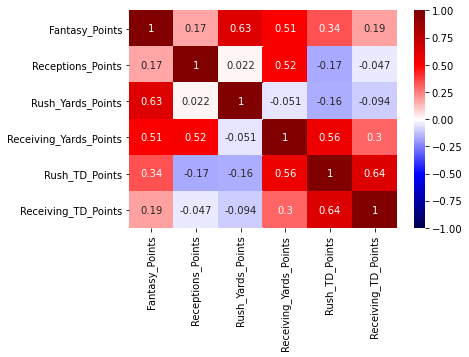

In [19]:
# example of a better corr matrix
# do this for all running backs, wide receivers, and quarterbacks
sns.heatmap(df_rushing_fantasy_2019.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

# more cmaps: https://matplotlib.org/examples/color/colormaps_reference.html

&lt;Figure size 1440x540 with 0 Axes&gt;

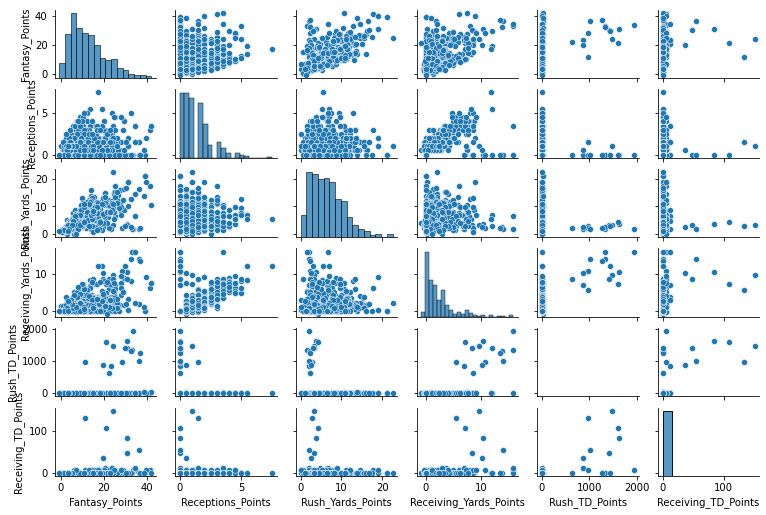

In [20]:
# do this for all running backs, wide receivers, and quarterbacks
plt.figure(figsize = [20,7.5])

sns.pairplot(df_rushing_fantasy_2019, height=1.2, aspect=1.5);

In [22]:
# Create your feature matrix (X) and target vector (y)
y, X = patsy.dmatrices('Fantasy_Points ~ Receptions_Points + Rush_Yards_Points + Receiving_Yards_Points + Rush_TD_Points + Receiving_TD_Points', data=df_rushing_fantasy_2019, 
return_type="dataframe")

# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

&lt;class &#39;statsmodels.iolib.summary.Summary&#39;&gt;
&quot;&quot;&quot;
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Fantasy_Points   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     233.7
Date:                Wed, 07 Oct 2020   Prob (F-statistic):          7.12e-122
Time:                        01:29:32   Log-Likelihood:                -1313.8
No. Observations:                 450   AIC:                             2640.
Df Residuals:                     444   BIC:                             2664.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P&gt;|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.1064      0.486      0.219      0.827      -0.848       1.061
Receptions_Points         -0.5310      0.287     -1.849      0.065      -1.095       0.033
Rush_Yards_Points          1.4518      0.054     26.897      0.000       1.346       1.558
Receiving_Yards_Points     1.5092      0.145     10.405      0.000       1.224       1.794
Rush_TD_Points             0.0061      0.002      3.305      0.001       0.002       0.010
Receiving_TD_Points       -0.0032      0.024     -0.134      0.893      -0.050       0.043
==============================================================================
Omnibus:                       52.078   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.384
Skew:                           0.846   Prob(JB):                     8.58e-16
Kurtosis:                       3.916   Cond. No.                         559.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
&quot;&quot;&quot;

In [25]:
# Define the model
lm1 = smf.ols('Fantasy_Points ~ Receptions_Points + Rush_Yards_Points + Receiving_Yards_Points + Rush_TD_Points + Receiving_TD_Points', data=df_rushing_fantasy_2019)

# Fit the model
fit1 = lm1.fit()

# Print summary statistics of the model's performance
fit1.summary()

&lt;class &#39;statsmodels.iolib.summary.Summary&#39;&gt;
&quot;&quot;&quot;
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Fantasy_Points   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     233.7
Date:                Wed, 07 Oct 2020   Prob (F-statistic):          7.12e-122
Time:                        01:31:00   Log-Likelihood:                -1313.8
No. Observations:                 450   AIC:                             2640.
Df Residuals:                     444   BIC:                             2664.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P&gt;|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.1064      0.486      0.219      0.827      -0.848       1.061
Receptions_Points         -0.5310      0.287     -1.849      0.065      -1.095       0.033
Rush_Yards_Points          1.4518      0.054     26.897      0.000       1.346       1.558
Receiving_Yards_Points     1.5092      0.145     10.405      0.000       1.224       1.794
Rush_TD_Points             0.0061      0.002      3.305      0.001       0.002       0.010
Receiving_TD_Points       -0.0032      0.024     -0.134      0.893      -0.050       0.043
==============================================================================
Omnibus:                       52.078   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.384
Skew:                           0.846   Prob(JB):                     8.58e-16
Kurtosis:                       3.916   Cond. No.                         559.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
&quot;&quot;&quot;

In [26]:
# Define the model
lm2 = smf.ols('Fantasy_Points ~ Rush_Yards_Points + Receiving_Yards_Points + Rush_TD_Points + Receiving_TD_Points', data=df_rushing_fantasy_2019)

# Fit the model
fit2 = lm2.fit()

# Print summary statistics of the model's performance
fit2.summary()

&lt;class &#39;statsmodels.iolib.summary.Summary&#39;&gt;
&quot;&quot;&quot;
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Fantasy_Points   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     289.7
Date:                Wed, 07 Oct 2020   Prob (F-statistic):          2.15e-122
Time:                        01:31:27   Log-Likelihood:                -1315.5
No. Observations:                 450   AIC:                             2641.
Df Residuals:                     445   BIC:                             2662.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P&gt;|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0.2060      0.457     -0.451      0.652      -1.104       0.692
Rush_Yards_Points          1.4589      0.054     27.024      0.000       1.353       1.565
Receiving_Yards_Points     1.3027      0.093     14.042      0.000       1.120       1.485
Rush_TD_Points             0.0083      0.001      5.915      0.000       0.006       0.011
Receiving_TD_Points       -0.0133      0.023     -0.576      0.565      -0.059       0.032
==============================================================================
Omnibus:                       50.137   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               65.317
Skew:                           0.837   Prob(JB):                     6.56e-15
Kurtosis:                       3.825   Cond. No.                         511.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
&quot;&quot;&quot;

In [27]:
# Define the model
lm3 = smf.ols('Fantasy_Points ~ Rush_Yards_Points + Receiving_Yards_Points + Rush_TD_Points', data=df_rushing_fantasy_2019)

# Fit the model
fit3 = lm3.fit()

# Print summary statistics of the model's performance
fit3.summary()

&lt;class &#39;statsmodels.iolib.summary.Summary&#39;&gt;
&quot;&quot;&quot;
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Fantasy_Points   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     386.7
Date:                Wed, 07 Oct 2020   Prob (F-statistic):          1.19e-123
Time:                        01:32:33   Log-Likelihood:                -1315.7
No. Observations:                 450   AIC:                             2639.
Df Residuals:                     446   BIC:                             2656.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P&gt;|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0.2191      0.456     -0.481      0.631      -1.115       0.677
Rush_Yards_Points          1.4583      0.054     27.038      0.000       1.352       1.564
Receiving_Yards_Points     1.3079      0.092     14.175      0.000       1.127       1.489
Rush_TD_Points             0.0078      0.001      6.919      0.000       0.006       0.010
==============================================================================
Omnibus:                       49.345   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.046
Skew:                           0.828   Prob(JB):                     1.24e-14
Kurtosis:                       3.820   Cond. No.                         510.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
&quot;&quot;&quot;

&lt;AxesSubplot:&gt;

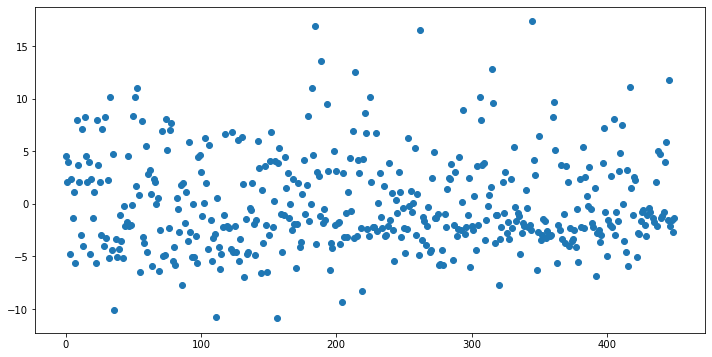

In [28]:
#Residual plot comparing actual vs. predicted values. In a good model we want our errors to be random. I'm not sure if the below looks too random. It seems to be between -5, so what does that mean? May be missing actual functional dependency underlying the data. This data may not be linear but let's keep going. 
fit1.resid.plot(style='o',figsize=(12,6))

&lt;AxesSubplot:&gt;

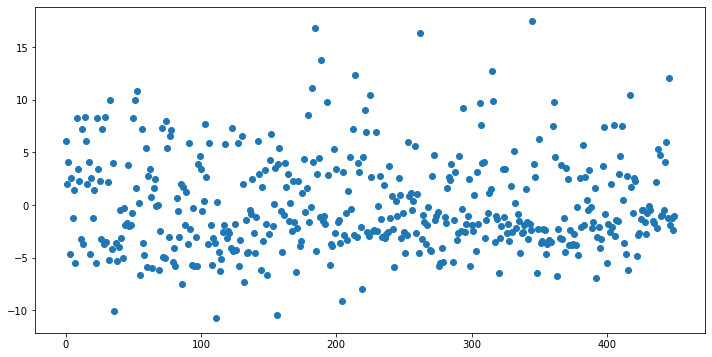

In [29]:
fit2.resid.plot(style='o',figsize=(12,6))

&lt;AxesSubplot:&gt;

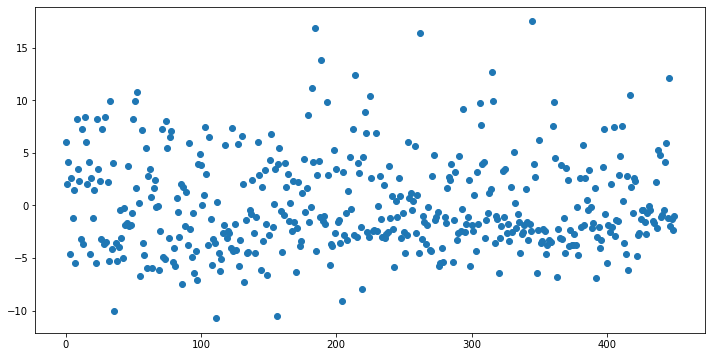

In [30]:
fit3.resid.plot(style='o',figsize=(12,6))

# Linear Regression

In [31]:
# Create an empty model
lr = LinearRegression()

# Model is analogous to 'Fantasy_Points ~ Total_Yards_Points + Total_TD_Points' model
# Predictor variables. All but the first one 
X = df_rushing_fantasy_2019.iloc[:, 1:]

# Response variables
y = df_rushing_fantasy_2019.iloc[:, 0]

# # Model fit to full dataset
lr.fit(X,y)

# # Prints R^2 for the model against the full dataset 
lr.score(X,y)

0.7246293958513741

In [45]:
YC_derrick_henry_rb_2019_array = np.array(derrick_henry_rb_2019_trim[['Yards_per_Carry']].values.tolist())

In [47]:
YC_derrick_henry[:-4]

array([[4.42],
       [5.47],
       [2.59],
       [3.7 ],
       [3.9 ],
       [1.87],
       [4.09],
       [4.69],
       [4.85],
       [8.17],
       [8.37]])

In [48]:
YC_derrick_henry[-4:]

array([[5.73],
       [5.72],
       [4.1 ],
       [6.59]])

Coefficients: 
 [21.07662871]
Mean squared error: 2074.19
Coefficient of determination: 0.12


[&lt;matplotlib.lines.Line2D at 0x14c1b48e0&gt;]

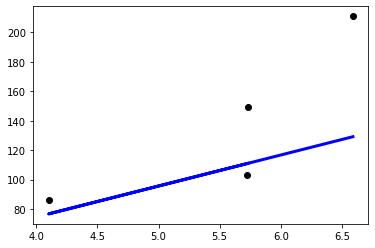

In [46]:
# Use only one feature: Carries/Game for Running Back
# X-Variable
YC_derrick_henry = YC_derrick_henry_rb_2019_array

# Split the data into training/testing sets
YC_derrick_henry_train = YC_derrick_henry[:-4]
YC_derrick_henry_test = YC_derrick_henry[-4:]

# Target Variable: Rushing Yards/Game for Running Back
# Y-Variable
yards_derrick_henry = derrick_henry_rb_2019_trim['Total_Yards']

# Split the targets into training/testing sets
yards_derrick_henry_train = yards_derrick_henry[:-4]
yards_derrick_henry_test = yards_derrick_henry[-4:]

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(YC_derrick_henry_train, yards_derrick_henry_train)

# Make predictions using the testing set
yards_derrick_henry_pred = regr.predict(YC_derrick_henry_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f' % mean_squared_error(yards_derrick_henry_test, yards_derrick_henry_pred))
# # The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(yards_derrick_henry_test, yards_derrick_henry_pred))

# # Plot outputs
plt.scatter(YC_derrick_henry_test, yards_derrick_henry_test,  color='black')
plt.plot(YC_derrick_henry_test, yards_derrick_henry_pred, color='blue', linewidth=3)

# plt.xticks(())
# plt.yticks(())

# plt.show()

# Polynomial Regression

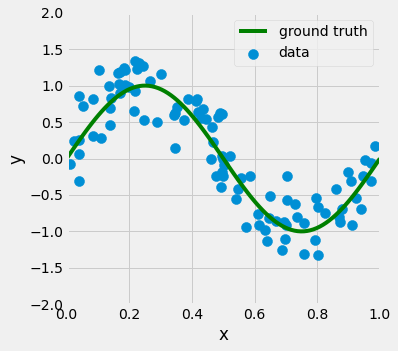

In [32]:
from IPython.core.pylabtools import figsize
figsize(5,5)
plt.style.use('fivethirtyeight')

# Seed random number generator to ensure everyone has random results
np.random.seed(9)

# Function that returns sin(2*pi*x)
def f(x):
    return np.sin(2 * np.pi * x)

# generate points used to plot
# Returns 100 evenly spaced numbers from 0 to 1
x_plot = np.linspace(0, 1, 100)

# generate points and keep a subset of them
n_samples = 100
# Generate the x values from the random uniform distribution between 0 and 1
X = np.random.uniform(0, 1, size=n_samples)[:, np.newaxis]
# Generate the y values by taking the sin and adding a random Gaussian (normal) noise term
y = f(X) + np.random.normal(scale=0.3, size=n_samples)[:, np.newaxis]

# Plot the training data against what we know to be the ground truth sin function
fig,ax = plt.subplots(1,1);
ax.plot(x_plot, f(x_plot), label='ground truth', color='green')
ax.scatter(X, y, label='data', s=100)
ax.set_ylim((-2, 2))
ax.set_xlim((0, 1))
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.legend();

In [136]:
# import PolynomialFeatures and make_pipeline for Polynomial Regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Plot the results of a pipeline against ground truth and actual data
def plot_approximation(est, ax, label=None):
    """Plot the approximation of ``est`` on axis ``ax``. """
    ax.plot(x_plot, f(x_plot), label='ground truth', color='green')
    ax.scatter(X, y, s=100)
    ax.plot(x_plot, est.predict(x_plot[:, np.newaxis]), color='red', label=label)
    ax.set_ylim((-2, 2))
    ax.set_xlim((0, 1))
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    ax.legend(loc='upper right',frameon=True)

Generate pipeline for a 3rd degree polynomial and try plotting function. 
- Use PolynomialFeatures(3) to create a generator of 3rd degree polynomials
- Feed this generator to make_pipeline along with a LinearRegression object to tell it to string together these operations when given a new set of input predictor variables.  This results in a new model object that has the same `fit()`, `score()`, `predict()`, etc functions
- Call `fit()` on our new object to fit a 3rd degree polynomial regression
- Send the result to our plotting function to view the results

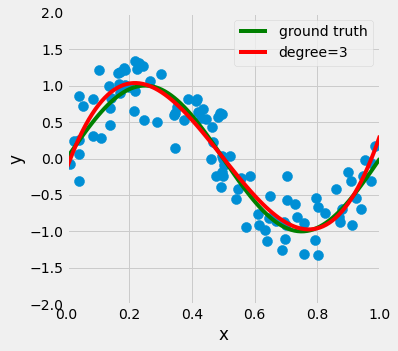

In [137]:
# Set up the plot
fig,ax = plt.subplots(1,1)
# Set the degree of our polynomial
degree = 3

# Generate the model type with make_pipeline
# This tells it the first step is to generate 3rd degree polynomial features in the input features and then run
# a linear regression on the resulting features
est = make_pipeline(PolynomialFeatures(degree), LinearRegression())

# Fit our model to the training data
est.fit(X, y)
# Plot the results
plot_approximation(est, ax, label='degree=%d' % degree)